In [1]:
# import numpy
# import pandas

In [2]:
import numpy as np
import pandas as pd
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

client = Client("IRIS")

class Fetch():
    def _getRefResponse(self):
        t0 = UTCDateTime(1989, 1, 1)
        inv = self.client.get_stations(network="SR", station="ANMO", channel="LH*", 
                            level="response", 
                            starttime=t0, endtime=t0+1)
        # client.save_response('SR.ANMO.dataless', 'SR', 'ANMO', '', '*', t0, t0 + 1, format="SEED")
        # inv.plot_response(min_freq=0.001)
        self.refResponse = inv
        return 0

    def _readTable():
        # get traces
        {}

        return 0

    def __init__(self, client):
        self.client = client
        self._getRefResponse()

In [22]:
from obspy.core import UTCDateTime
UTCDateTime("2009-365T9:23:24.0Z")

2009-12-31T09:23:24.000000Z

In [28]:
import pandas as pd
table = pd.read_csv("/Users/jun/Downloads/drive-download-20220512T014633Z-001/Pcomb.4.07.09.table", delim_whitespace=True)
table[table['sec']>=60]
# for index, row in table[0:10].iterrows():
    # print(row)

,phase,residual,error,ellipcor,crustcor,obstim,calctim,year,day,hour,min,sec,eqlat,eqlon,eqdep,station,stalat,stalon,dist,azi
14948,P,3.738,2.0,0.195,-0.428,419.8473,416.1090,1988,343,12,58,60.0,6.92,-82.74,10.0,ANMO,34.946,253.543,35.417,325.239
14949,P,3.953,2.0,0.257,-0.397,479.0323,475.0794,1988,343,12,58,60.0,6.92,-82.74,10.0,PAS,34.148,241.828,42.459,314.584
14950,P,4.854,2.0,0.256,-0.764,467.6888,462.8350,1988,343,12,58,60.0,6.92,-82.74,10.0,PFO,33.609,243.545,40.964,315.042
14951,P,3.682,1.0,0.303,0.684,347.5404,343.8579,1988,343,12,58,60.0,6.92,-82.74,10.0,ZOBO,-16.269,291.875,27.205,147.988
18013,P,3.371,3.0,0.364,0.420,778.5012,775.1298,1990,108,18,32,60.0,1.32,123.02,19.0,ANTO,39.869,32.794,89.337,309.676
18014,P,4.994,2.0,0.514,-0.377,511.2368,506.2424,1990,108,18,32,60.0,1.32,123.02,19.0,HYB,17.420,78.550,46.534,292.854
18015,P,4.443,3.0,0.045,-1.039,661.0176,656.5751,1990,108,18,32,60.0,1.32,123.02,19.0,PAF,-49.351,70.213,67.797,214.239
18016,P,6.201,3.0,0.090,-0.412,532.8149,526.6143,1990,108,18,32,60.0,1.32,123.02,19.0,TAU,-42.910,147.320,49.163,156.445
19774,P,4.477,3.0,-0.018,0.572,363.4810,359.0043,1990,298,4,53,60.0,35.12,70.49,113.0,ANTO,39.869,32.794,30.131,290.361
19775,P,3.012,2.0,-0.044,-0.110,482.2055,479.1931,1990,298,4,53,60.0,35.12,70.49,113.0,AQU,42.354,13.403,44.390,297.184


/Users/jun/.local/share/virtualenvs/phasepick-mEodVLkE/lib/python3.9/site-packages/obspy/core/stream.py:3134: UserWarning: No matching response information found.
  warnings.warn(str(e))


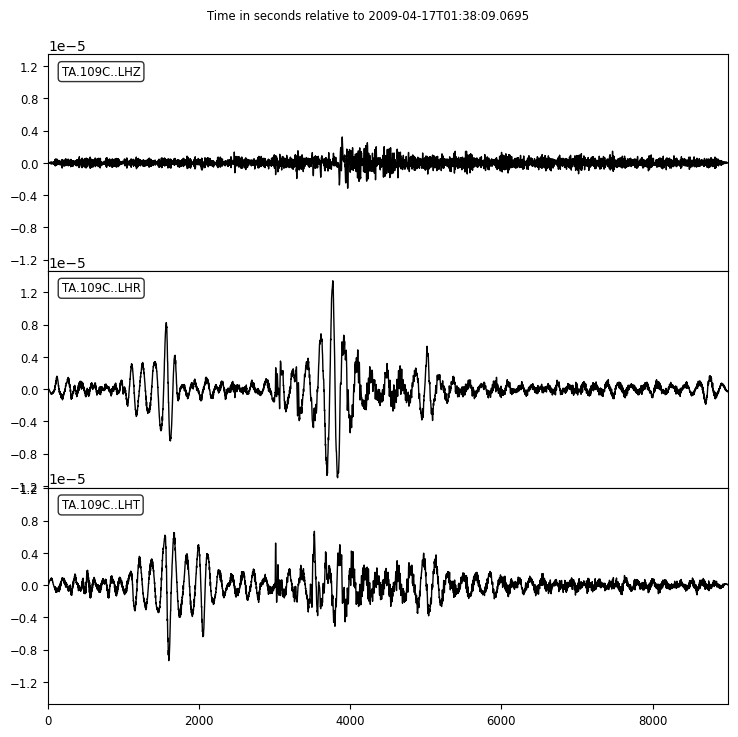

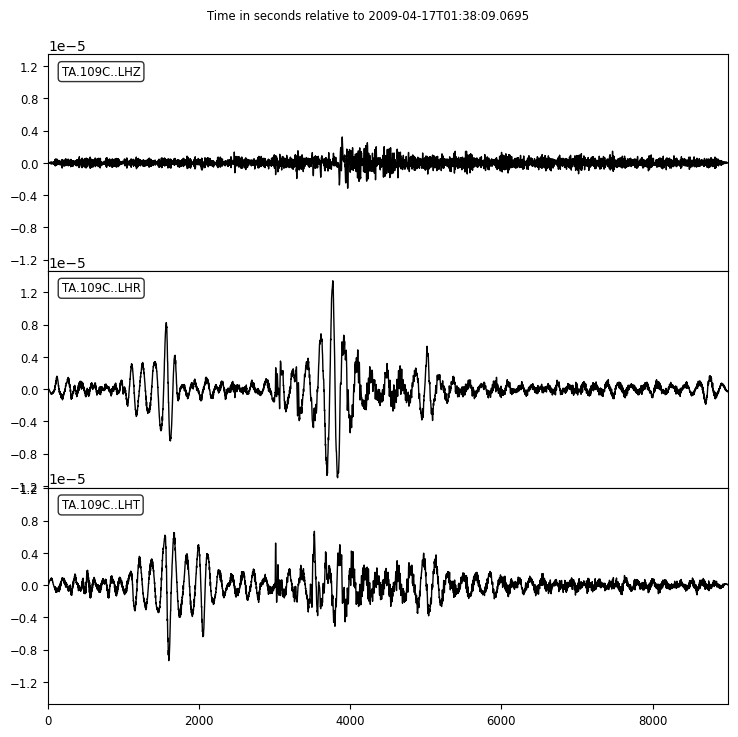

In [3]:
from obspy.geodetics.base import gps2dist_azimuth
# t = UTCDateTime("1995-01-03T16:11:57.080")
# st = client.get_waveforms("II", "FFC", "00", "LHZ", t, t + 2 * 60 * 60).detrend("spline", order=2, dspline=500).filter('lowpass', freq=0.03, corners=2, zerophase=True)

def get_all(t):
    st_raw = client.get_waveforms("TA", "109C", "*", "LH*", t - 0.5 * 60 * 60, t + 2 * 60 * 60, attach_response=True)
    cat = client.get_events(starttime=t-1, endtime=t+1, minmagnitude=5, catalog="ISC")
    if not len(cat) == 1:
        raise ValueError("None or more than 1 events found.")

    inv = client.get_stations(network="TA", station="109C")
    baz = gps2dist_azimuth(lat1=cat[0].origins[0].latitude, lon1=cat[0].origins[0].longitude, lat2=inv[0][0].latitude, lon2=inv[0][0].longitude)
    return st_raw, baz

t = UTCDateTime("2009-04-17T02:08:8.700")
if not 'st_raw' in globals():
    st_raw, baz = get_all(t)
elif abs(st_raw[0].stats.starttime - t) > 2:
    st_raw, baz = get_all(t)  
    
st = st_raw.copy()
st[0:3] = st.remove_response(output="DISP", pre_filt=(0.005, 0.006, 30.0, 35.0)) \
    .attach_response(inv)

st = st.rotate('NE->RT', back_azimuth=baz[2]) \
    .resample(1.00)
    # .detrend("spline", order=2, dspline=500) \
    # .filter('lowpass', freq=0.05, corners=2, zerophase=False) \
    # .filter('bandpass', freqmin=0.03, freqmax=0.05, corners=2, zerophase=True)
st.plot(type='relative')
# st.plot(starttime=t+2000, endtime=t+2500)

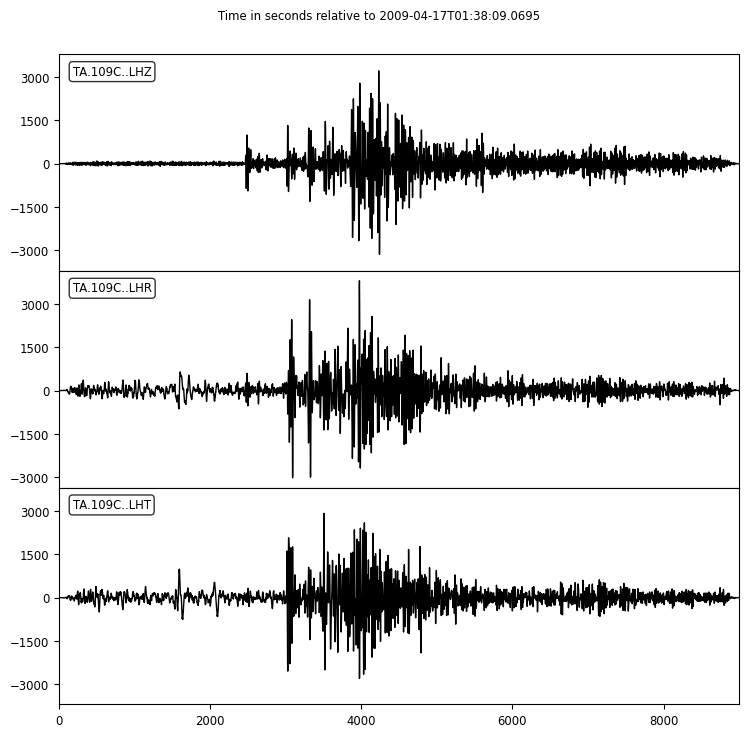

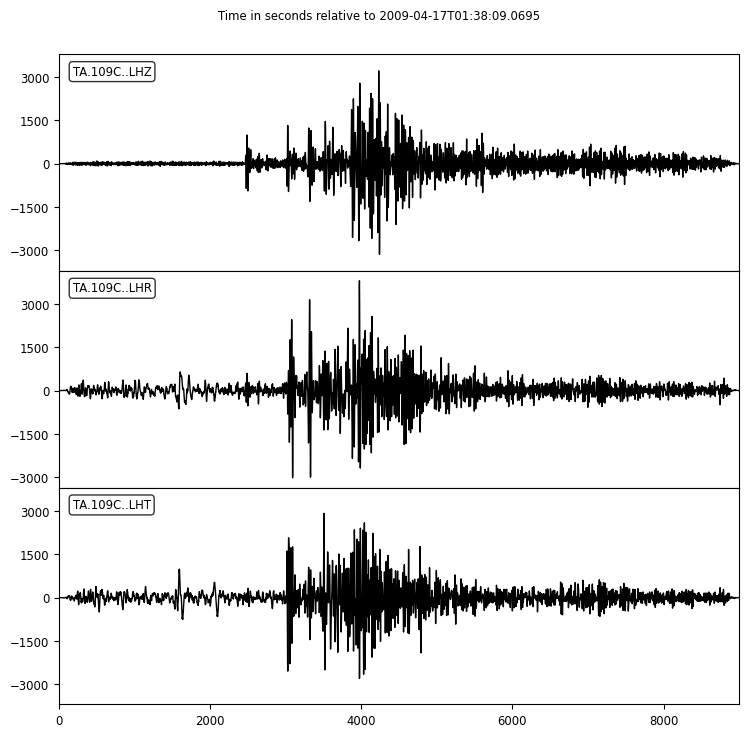

In [4]:
from obspy.signal.invsim import simulate_seismometer
# st2 = st_raw.copy().remove_response(output="DISP", pre_filt=(0.005, 0.006, 30.0, 35.0))
# st2[0].attach_response(inv)
# inv[0][0][0].response.instrument_sensitivity
# inv[0][0][0].response.get_paz().stage_gain
st_sync = st_raw.copy() \
    .remove_response(output="DISP", pre_filt=(0.005, 0.006, 30.0, 35.0)) \

for i in range(3):
    sts2 = {'gain': inv[0][0][i].response.get_paz().stage_gain,
        'poles': inv[0][0][i].response.get_paz().poles,
        'sensitivity': inv[0][0][i].response.instrument_sensitivity.value,
        'zeros': inv[0][0][i].response.get_paz().zeros}
    st_sync[i].data = simulate_seismometer(st_sync[i].data, samp_rate=st_sync[0].stats.sampling_rate, paz_simulate=sts2)

st_sync = st_sync.rotate('NE->RT', back_azimuth=baz[2]) \
    .resample(1.00)
    # .detrend("spline", order=2, dspline=500) \
    # .filter('lowpass', freq=0.05, corners=2, zerophase=False) \
    # .filter('bandpass', freqmin=0.03, freqmax=0.05, corners=2, zerophase=True)
st_sync.plot(type='relative')

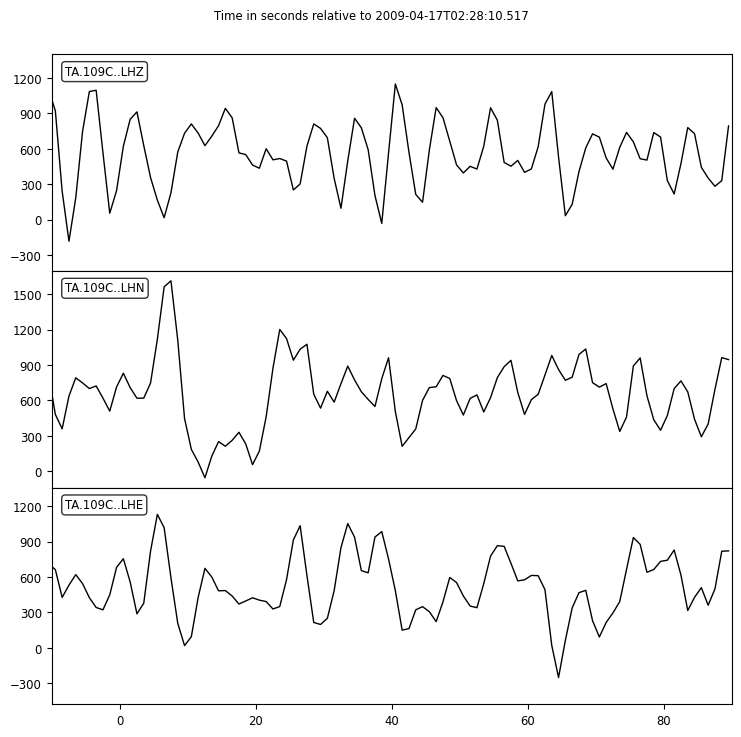

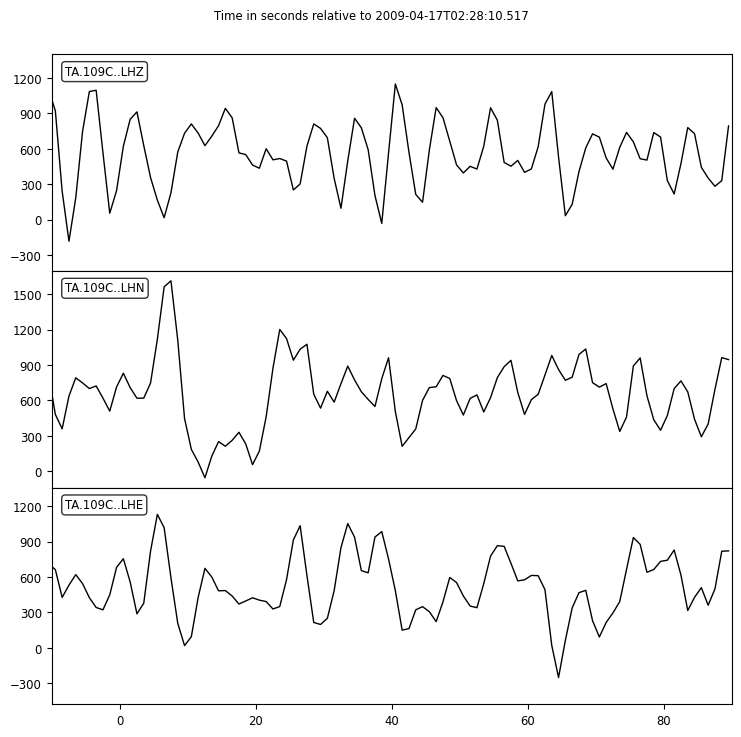

In [5]:
pick = 1201.8170
st_raw.plot(starttime=t+pick-10, endtime=t+pick+90, reftime=t+pick, type='relative')


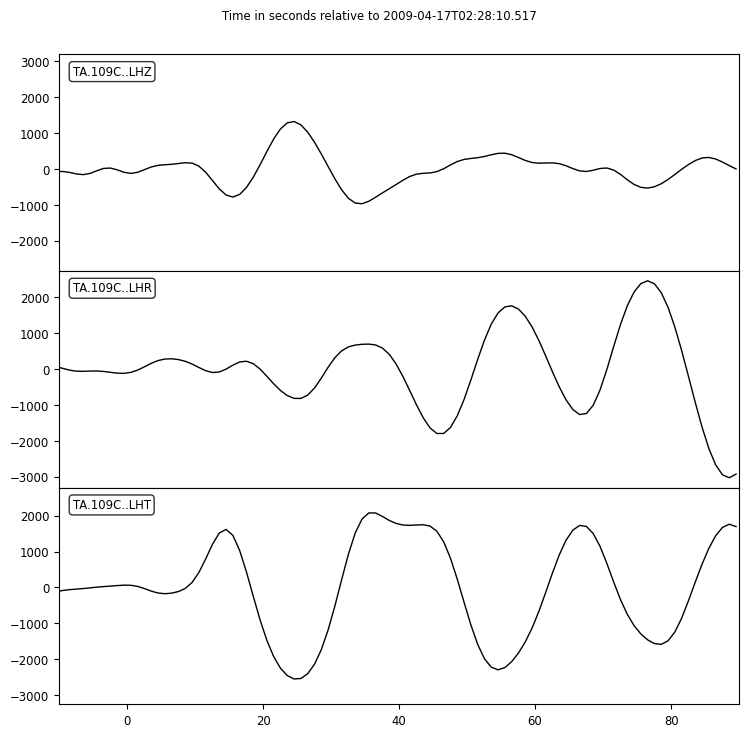

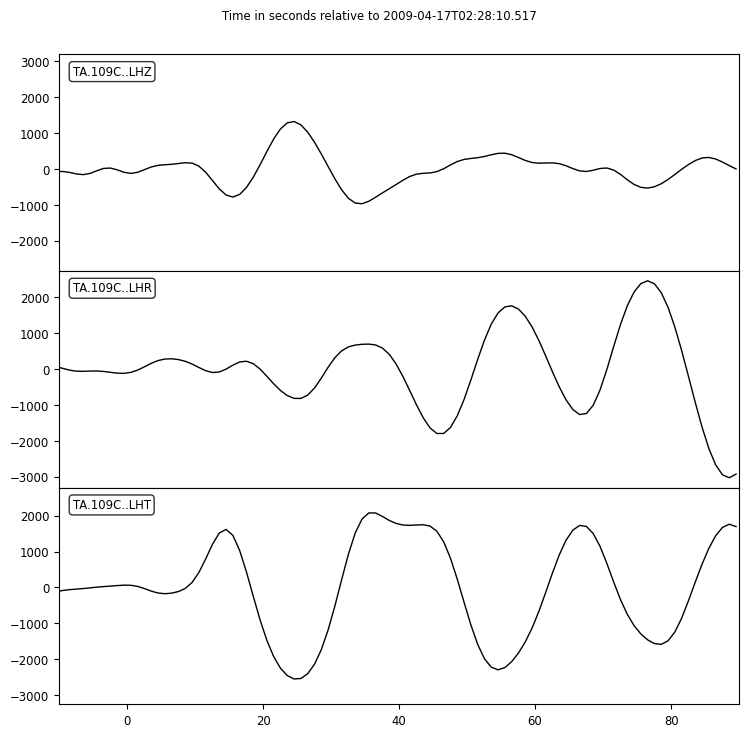

In [6]:
st_sync.plot(starttime=t+pick-10, endtime=t+pick+90, reftime=t+pick, type='relative')

In [116]:
baz

(8144572.090698388, 61.30957618026633, 324.9251127676964)

In [4]:
from obspy import UTCDateTime
# starttime = UTCDateTime("1995-01-03T16:11:00")
# endtime = UTCDateTime("1995-01-03T16:12:00")
starttime = UTCDateTime("1995-01-03T00:00:00")
endtime = UTCDateTime("1995-01-03T23:59:59")
# starttime._set_julday(3)
# endtime._set_julday(3)

In [5]:
# cat = client.get_events(starttime=starttime, endtime=endtime, catalog="ISC")
cat = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=5, catalog="ISC")
print(cat)

6 Event(s) in Catalog:
1995-01-03T16:11:57.080000Z | -57.679,  -65.967 | 5.7 mw
1995-01-03T12:58:45.610000Z |  -3.462, +134.205 | 5.0 mb
1995-01-03T07:02:45.550000Z | +40.500, +143.656 | 5.0 mb
1995-01-03T06:49:20.350000Z | -19.710, -178.084 | 5.3 mb
1995-01-03T06:01:23.830000Z | +40.470, +143.612 | 5.1 mb
1995-01-03T02:54:54.270000Z | -56.201,  -27.390 | 5.5 mb


/Users/jun/.local/share/virtualenvs/phasepick-mEodVLkE/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


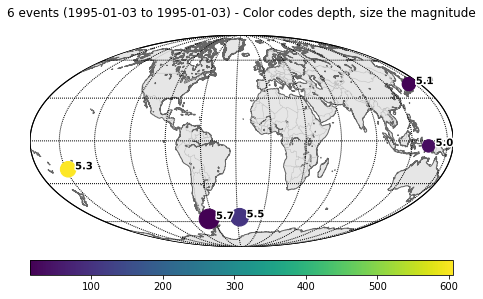

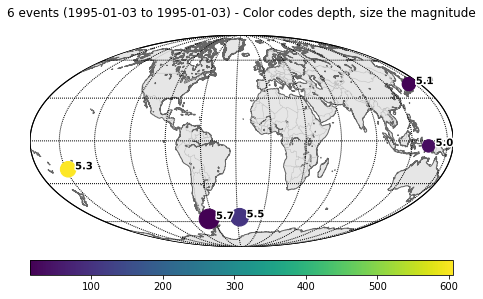

In [6]:
# import matplotlib.pyplot as plt
# To fix a flipped global map, negative sign has been added at /Users/jun/.local/share/virtualenvs/phasepick-mEodVLkE/lib/python3.9/site-packages/obspy/imaging/maps.py:342
cat.plot()

In [11]:
from obspy.clients.fdsn import Client
client = Client("RESIF")

In [8]:
import json
with open('sta2net.json') as user_file:
    parsed_json = json.load(user_file)
parsed_json['ANMO']['network']

'SR'

In [3]:
import os
import h5py
import numpy as np
import pandas as pd
def open_hdf5(filename):
    os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
    try:
        db = h5py.File(filename, mode='a')
    except:
        db = h5py.File(filename, mode='w')
    return db

tbPcomb = pd.read_csv("/Users/jun/Downloads/drive-download-20220512T014633Z-001/Pcomb.4.data.network.table" ,delim_whitespace=True)

In [5]:
t0 = UTCDateTime(2020, 7, 20)
sta = client.get_stations(network="XF", station="*", channel="*", 
                    #  level="response", 
                     starttime=t0, endtime=t0+1)
print(sta)

FDSNNoDataException: No data available for request.
HTTP Status code: 204
Detailed response of server:



In [27]:
sta.networks[0].code

'SY'

In [30]:
cli_t0

1996-06-08T23:19:00.000000Z

In [12]:
cli_sta = client.get_stations(station="SP*")
cli_sta

Inventory created at 2022-06-20T04:47:02.000000Z
	Created by: RESIF WEB SERVICE: fdsnws-station | version: 1.1.1 
		    http://ws.resif.fr/fdsnws/station/1/query?station=SP%2A
	Sending institution: RESIF-SI (RESIF-DC)
	Contains:
		Networks (2):
			FR, G
		Stations (2):
			FR.SPIF (crête de Spivol)
			G.SPB (Sao Paulo, Brazil)
		Channels (0):


In [ ]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client = Client("IRIS")
sta2net = {}
staMissing = {}
for index, row in tbPcomb.iterrows():
    if not row['station'] in staMissing:
        if not row['station'] in sta2net:
            print(row['station'])
            cli_t0 = UTCDateTime("%.4d%.3d" % (row['year'], row['day']), iso8601=True)
            cli_t0 = cli_t0 + row['hour']*3600 + row['min']*60
            try:
                cli_sta = client.get_stations(network=row['network'], station=row['station'],
                        starttime=cli_t0, endtime=cli_t0+1)
                sta2net[row['station']] = cli_sta.networks[0].code
            except:
                staMissing[row['station']] = row['network']
        


In [3]:
import os
import json
sta2net = {}
directories = os.listdir('./training')
for directory in directories:
    if not directory == ".DS_Store":
        filenames = os.listdir(f'./training/{directory}')
        for filename in filenames:
            keys = filename.split(".")
            if not keys[1] in sta2net:
                sta2net[keys[1]] = {"fullname": keys[1], "network": keys[0]}
with open('sta2net.json', 'w') as outjson:
    json.dump(sta2net, outjson)

In [4]:
import pickle
from obspy.clients.fdsn import Client
from picker import Event,Station,Record,SeismicData
client = Client('IRIS')
finished = []

with open('data_fetched.pkl', 'rb') as inp:
    data = pickle.load(inp)

for event in data.events:
    srctime = event.srctime
    srctime.precision = 3
    starttime = srctime - 0.5 * 60 * 60
    endtime = srctime + 2 * 60 * 60
    for station in event.stations:
        key = station.labelsta['name']

        if (not key in finished) and (not key in sta2net):
            finished.append(key)
            try:
                inv = client.get_stations(station=f"{key}", starttime=starttime, endtime=endtime)

            except:
                try:
                    inv = client.get_stations(starttime=starttime, endtime=endtime,
                            minlatitude=station.labelsta['lat']-0.02, maxlatitude=station.labelsta['lat']+0.02,
                            minlongitude=station.labelsta['lon']-0.02, maxlongitude=station.labelsta['lon']+0.02)
                except:
                    # print(srctime, key, '... X (station not exists)')
                    pass

            # print(inv.networks[0].code)
            for network in inv.networks:
                if network.code == "SY":
                    inv.networks.remove(network)

            if len(inv.networks) > 0 and (key != inv.networks[0].stations[0].code):
                try:
                    print(srctime, f"[{key}] network-fullname ({inv.networks[0].code}-{inv.networks[0].stations[0].code})")
                except:
                    print(srctime, f"[{key}] network-fullname ({inv.networks[0].code}-{inv.networks[0].stations[0].code})", '... X (data not exists)')

            

1996-06-08T23:19:15.100Z [POPX] network-fullname (XC-LU2A)
1997-10-28T06:15:17.300Z [HELX] network-fullname (CN-SCHQ)
2002-10-12T20:09:11.500Z [SER2] network-fullname (CN-LLLB)
2004-05-03T04:36:50.000Z [BDA2] network-fullname (CN-LLLB)
2007-01-05T16:52:22.400Z [O002] network-fullname (CN-ULM)
2007-01-05T16:52:22.400Z [O058] network-fullname (CN-ULM)
2007-01-05T16:52:22.400Z [SP85] network-fullname (CN-ULM)
2007-01-05T16:52:22.400Z [SP87] network-fullname (CN-ULM)
2007-01-05T16:52:22.400Z [SP93] network-fullname (CN-ULM)
2007-01-05T16:52:22.400Z [SP97] network-fullname (CN-ULM)
2007-01-05T16:52:22.400Z [SPA7] network-fullname (NO-SPA3)
2007-01-05T16:52:22.400Z [SPA8] network-fullname (NO-SPA3)
2007-01-05T16:52:22.400Z [SPB7] network-fullname (NO-SPB3)
2007-01-05T16:52:22.400Z [SPB9] network-fullname (NO-SPB3)
2007-01-05T16:52:22.400Z [SPC5] network-fullname (NO-SPB3)
2007-01-05T16:52:22.400Z [SPC6] network-fullname (NO-SPB3)
2007-01-05T16:52:22.400Z [SPC8] network-fullname (NO-SPB3)
200

In [5]:
import pandas as pd
df = pd.DataFrame([{'a':1, 'b':2}, {'a':2, 'b':4}])
df

,a,b
0,1,2
1,2,4


In [4]:
tbPcomb

,phase,residual,error,ellipcor,crustcor,obstim,calctim,year,day,hour,...,sec,eqlat,eqlon,eqdep,station,network,stalat,stalon,dist,azi
0,P,3.231,2.3,0.046,-0.049,790.1756,786.9446,1976,1,1,...,39.6,-28.61,-177.64,59.0,ANMO,SR,34.946,253.543,92.216,51.093
1,P,4.188,2.3,0.250,-0.048,404.7679,400.5803,1976,1,1,...,39.6,-28.61,-177.64,59.0,CTA,HG,-20.088,146.254,33.867,276.340
2,P,2.571,1.3,0.297,-1.511,574.5100,571.9387,1976,1,1,...,39.6,-28.61,-177.64,59.0,GUMO,SR,13.588,144.866,55.450,314.061
3,P,2.644,1.3,0.152,-1.490,558.4223,555.7786,1976,1,1,...,39.6,-28.61,-177.64,59.0,KIP,HG,21.423,201.985,53.227,22.997
4,P,1.600,1.3,0.584,1.285,817.8323,816.2324,1976,1,1,...,39.6,-28.61,-177.64,59.0,ZLP,HG,-16.270,291.875,98.596,113.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247153,P,2.798,2.3,-0.362,-0.178,461.3046,458.5070,2009,365,9,...,24.0,-59.40,-150.98,10.0,TAU,G,-42.910,147.320,40.440,265.777
247154,P,1.871,2.3,-0.084,-0.027,770.0510,768.1802,2009,365,9,...,24.0,-59.40,-150.98,10.0,UGM,G,-7.913,110.523,87.557,258.702
247155,P,6.297,2.3,-0.326,-0.492,355.7864,349.4895,2009,365,9,...,24.0,-59.40,-150.98,10.0,WHZ,G,-45.894,167.947,27.833,280.645
247156,P,1.454,2.3,-0.163,-0.034,643.2680,641.8143,2009,365,9,...,24.0,-59.40,-150.98,10.0,WRAB,G,-19.934,134.360,65.258,272.554


In [13]:
#read

from obspy import read, UTCDateTime
from picker import Event

savedir = f"./training/2009-04-17T02:08:08.700Z"
print(savedir)
st = read(f"{savedir}/TA.H14A.LH.obspy")

./training/2009-04-17T02:08:08.700Z


In [35]:
t = UTCDateTime("2009-04-17T02:08:08.700Z")
f"_{t.year:4d}{t.month:02d}{t.day:02d}{t.hour:02d}{t.minute:02d}{t.second:02d}_EV"

'_20090417020808_EV'

In [41]:
import glob
glob.glob('/Users/jun/phasepick/training/1976-01-01T12:09:39.600Z/*ANMO*')[0].split('/')[-1].split('.')[0]

'SR'

In [45]:
# st[0].data
import numpy as np
event_data = np.transpose([st[0].data, st[1].data, st[2].data])
event_data

array([ 860, 1123, 1372, ...,  993, 1022, 1095], dtype=int32)

In [1]:
from picker import *
from obspy.clients.fdsn import Client

client = Client('IRIS')
with open('data.pkl', 'rb') as inp:
    loaddata = pickle.load(inp)
data = SeismicData(client, [])
data.events = loaddata.events

In [ ]:
print(data.events[0].stations[0].labelsta['name'])
print([ [station.labelsta['name'] for station in event.stations] for event in data.events])